In [1]:
import os, sys, numpy as np, pandas as pd, tensorflow as tf, re, codecs, json, time
import pickle, collections, random, math, numbers, scipy.sparse as sp, itertools, shutil

def reload(mName):
    import importlib
    if mName in sys.modules:
        del sys.modules[mName]
    return importlib.import_module(mName)

from sklearn.preprocessing import minmax_scale
from scipy.sparse.linalg import svds
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
plt.style.use('ggplot')

utils = reload('utils.utils')
from utils.utils import *

np.set_printoptions(precision=4, suppress=True, linewidth=100)
np.random.seed(42)

/Users/YiHsien/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<br/>
<br/>
<br/>
## Movielens smallest data set

In [2]:
ratings, movies, uidEnc, midEnc, nUsers, nMovies, midMap, tr, te, trRatingMat, teRatingMat = prepare()

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,0,30,2.5,1260759144
1,0,833,3.0,1260759179
2,0,859,3.0,1260759182
3,0,906,2.0,1260759185
4,0,931,4.0,1260759205


In [4]:
# movies profile
movies.head()

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,Jumanji (1995),Adventure|Children|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,4,Father of the Bride Part II (1995),Comedy


In [11]:
trRatingMat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

<br/>
<br/>
<br/>
### Split Train and Test Data, Making Rating Matrix

In [12]:
print("train interaction matrix shape: ", trRatingMat.shape, "test interaction matrix shape: ", teRatingMat.shape)
print("train.shape: ", tr.shape, "test.shape: ", te.shape)
print()
print(tr.head())
print()
print(te.head())

train interaction matrix shape:  (671, 9125) test interaction matrix shape:  (671, 9125)
train.shape:  (69399, 4) test.shape:  (30605, 4)

   userId  movieId  rating   timestamp
0       0      931     4.0  1260759205
1       0     1515     4.0  1260759191
2       0       30     2.5  1260759144
3       0      833     3.0  1260759179
4       0      859     3.0  1260759182

   userId  movieId  rating   timestamp
0       0     1665     4.0  1260759139
1       0     1708     3.0  1260759194
2       0     1743     2.0  1260759198
3       0     1815     2.0  1260759108
4       0     1962     2.5  1260759113


### Data Function
1. batch產生資料, 每筆資料有三個欄位 user id, movie id, rating

In [13]:
def dataFn(data, n_batch=256, shuffle=False):
    data = data.copy()
    # 讓rating分數只有1 or 0(喜歡 or 不喜歡)
    # data["rating"] = data.rating.map(lambda e: e >= 4).astype(int)
    def _dataFn():
        idx = utils.get_minibatches_idx(len(data), n_batch, shuffle=shuffle)
        for ind in idx:
            rows = data.iloc[ind]
            yield rows.userId.values, rows.movieId.values, rows.rating.values
    return _dataFn

# preview training data
for u, i, r in dataFn(tr, n_batch=10)():
    print("users:\n", u)
    print("items:\n", i)
    print("ratings:\n", r)
    break

users:
 [0 0 0 0 0 0 0 0 0 0]
items:
 [ 931 1515   30  833  859  906 1017 1041 1047 1083]
ratings:
 [4.  4.  2.5 3.  3.  2.  2.  2.  2.  3.5]


<br/>
<br/>
<br/>

## Tensorflow Model Based Matrix Factorization

In [16]:
class ModelMF(object):
    def __init__(self, user_num, item_num, dim=5, learning_rate=0.1, reg=0.05, modelDir="./model/model_mf"):
        self.user_num = user_num
        self.item_num = item_num
        self.dim = dim
        self.learning_rate = learning_rate
        self.reg = reg
        self.modelDir = modelDir
        graph = tf.Graph()
        with graph.as_default():
            # inputs parts
            graph_inputs(self)
            # embedding parts
            graph_embedding(self)
            # computation parts
            graph_computation(self)
            # loss parts
            graph_loss(self)
            self.saver = tf.train.Saver(tf.global_variables())
            self.graph = graph
            
    def fit(self, sess, trainGen, testGen, reset=False, nEpoch=50):
        return fit(self, sess, trainGen, testGen, reset=reset, nEpoch=nEpoch)
    
    def predict(self, sess, users: list):
        return predict(self, sess, users)
    
    def resetModel(self, modelDir):
        """刪除model dir"""
        shutil.rmtree(path=modelDir, ignore_errors=True)
        os.makedirs(modelDir)
        
    def ckpt(self, sess, modelDir):
        """load latest saved model"""
        return ckpt(self, sess, modelDir)
    
    def epochLoss(self, sess, dataGen, tpe="rmse"):
        """return RMSE error from all valid data for eval"""
        totLoss, totCnt = 0, 0
        for users, items, rates in dataGen():
            lossTensor = self.rmse_loss if tpe == "rmse" else self.mae_loss
            loss = sess.run(lossTensor, feed_dict={self.user_batch: users,
                                                   self.item_batch: items,
                                                   self.rate_batch: rates,
                                                   self.isTrain: False})
            totLoss += (loss ** 2 if tpe == "rmse" else loss) * len(users)
            totCnt += len(users)
        return np.sqrt(totLoss / totCnt) if tpe == "rmse" else totLoss / totCnt
    
    def evaluateRMSE(self, sess, dataGen):
        """計算root mean square error"""
        self.ckpt(sess, self.modelDir)
        return self.epochLoss(sess, dataGen, tpe="rmse")

    def evaluateMAE(self, sess, dataGen):
        """計算 mean absolutely error"""
        self.ckpt(sess, self.modelDir)
        return self.epochLoss(sess, dataGen, tpe="mae")

## 設定Inputs placeholders: User、Item、Rate

In [17]:
def graph_inputs(self):
    with tf.variable_scope("inputs"):
        self.isTrain = tf.placeholder(tf.bool, None)
        # user data
        self.user_batch = tf.placeholder(tf.int32, shape=[None], name="id_user")
        # item data
        self.item_batch = tf.placeholder(tf.int32, shape=[None], name="id_item")
        # labels
        self.rate_batch = tf.placeholder(tf.float32, shape=[None])

## Embedding部分 = One Hot Encoding + Linear Transformation<br/>
### tensorflow 提供 tf.nn.embedding_lookup function
1. user + user bias and item + item Bias 都使用embedding
![embedding explain](https://github.com/CloudMile/recommendation_engine_course/blob/master/embedding_explain.jpg?raw=true)

In [18]:
def graph_embedding(self):
    initFn = tf.glorot_uniform_initializer()
    # Using a global bias term
    self.bias_global = tf.Variable(initFn(shape=[]), name="bias_global")
    with tf.variable_scope("embedding"):
        # User and item bias variables
        self.w_bias_user = tf.Variable(initFn(shape=[self.user_num]), name="embd_bias_user")
        self.w_bias_item = tf.Variable(initFn(shape=[self.item_num]), name="embd_bias_item")
        self.w_user = tf.Variable(initFn(shape=[self.user_num, self.dim]), name="embd_user")
        self.w_item = tf.Variable(initFn(shape=[self.item_num, self.dim]), name="embd_item")
        # ------------------------------------------------------------------------------------------
        # embedding_lookup: Looks up 'ids' in a list of embedding tensors
        # Bias embeddings for user and items, given a batch
        # shape of self.bias_user = (user_batch,)
        # shape of self.bias_item = (item_batch,)
        self.bias_user = tf.nn.embedding_lookup(self.w_bias_user, self.user_batch, name="bias_user")
        self.bias_item = tf.nn.embedding_lookup(self.w_bias_item, self.item_batch, name="bias_item")
        # Weight embeddings for user and items, given a batch
        # shape of self.embd_user = (user_batch * dim)
        # shape of self.embd_item = (item_batch * dim)
        self.embd_user = tf.nn.embedding_lookup(self.w_user, self.user_batch, name="embedding_user")
        self.embd_item = tf.nn.embedding_lookup(self.w_item, self.item_batch, name="embedding_item")

## Computation: 帶公式
$$ u_i \cdot m_j + b_u + b_m + b_{global} $$

In [19]:
def graph_computation(self):
    with tf.variable_scope("computation"):
        # Do: 若有overfitting後可嘗試dropout
        # self.embd_user = tf.layers.dropout(self.embd_user, rate=0.5, training=self.isTrain)
        # self.embd_item = tf.layers.dropout(self.embd_item, rate=0.5, training=self.isTrain)
        
        infer = tf.reduce_sum(tf.multiply(self.embd_user, self.embd_item), 1)
        infer = tf.add(infer, self.bias_global)
        infer = tf.add(infer, self.bias_user)
        self.infer = tf.add(infer, self.bias_item, name="infer")

## Loss and Regularizer Term
1. 使用MSE優化整個model
2. RMSE and MAE loss節點並不在training graph中, 主要在eval的時候可以觀察變化
3. 使用 L2 regularization

In [20]:
def graph_loss(self):
    with tf.variable_scope("loss"):
        # Do: try L1 or L2 regularization term
        self.regularizer = self.reg * (tf.reduce_sum(tf.abs(self.embd_user)) + tf.reduce_sum(tf.abs(self.bias_user)) +
                                       tf.reduce_sum(tf.abs(self.embd_item)) + tf.reduce_sum(tf.abs(self.bias_item)))
        # self.regularizer = self.reg * (tf.nn.l2_loss(self.embd_user) + tf.nn.l2_loss(self.bias_user) +
        #                                tf.nn.l2_loss(self.embd_item) + tf.nn.l2_loss(self.bias_item))
        
        # Do: try others loss: l2_loss, mae_loss
        # # l2_loss: Computes half the L2 norm of a tensor without the sqrt => sum(t ** 2) / 2
        # self.loss = tf.nn.l2_loss(self.infer - self.rate_batch) + self.regularizer
        self.loss = tf.losses.mean_squared_error(labels=self.rate_batch, predictions=self.infer) + self.regularizer
        
        # for eval
        self.rmse_loss = tf.sqrt(
            tf.reduce_mean(
                tf.losses.mean_squared_error(labels=self.rate_batch, predictions=self.infer)), name="rmse_loss")
        self.mae_loss = tf.reduce_mean(tf.abs(self.infer - self.rate_batch), name="mae_loss")

    with tf.variable_scope("train"):
        # Do: try others optimizer
        # self.train_op = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.loss)
        # self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        self.train_op = tf.train.AdagradOptimizer(self.learning_rate).minimize(self.loss)

## Fit: Training Function
1. reset: if True, clean the checkpoints save data
2. 計算epoch loss: 每個batch的loss * batch數量總和後除以epoch總數
3. training過程中會記錄valid loss, 只會儲存最低的loss => 另一種對付overfitting的方式

In [21]:
def fit(self, sess, trainGen, testGen, reset=False, nEpoch=50):
    """model training"""
    sess.run(tf.global_variables_initializer())
    if reset:
        print("reset model: clean model dir: {} ...".format(self.modelDir))
        self.resetModel(self.modelDir)
    self.ckpt(sess, self.modelDir)

    start = time.time()
    print("%s\t%s\t%s\t%s" % ("Epoch", "Train Error", "Val Error", "Elapsed Time"))
    minLoss = 1e7
    for ep in range(1, nEpoch + 1):
        tr_loss, tr_total = 0, 0
        for i, (users, items, rates) in enumerate(trainGen(), 1):
            loss, _ = sess.run([self.rmse_loss, self.train_op],
                                  feed_dict={self.user_batch: users,
                                             self.item_batch: items,
                                             self.rate_batch: rates,
                                             self.isTrain: True})
            tr_loss += loss**2 * len(users)
            tr_total += len(users)
            print("\rtrain loss: {:.3f}".format(loss), end="")
        if testGen is not None:
            epochLoss = self.epochLoss(sess, testGen)

        tpl = "\r%02d\t%.3f\t\t%.3f\t\t%.3f secs"
        # 紀錄最小valid loss, 若大於之後的loss, 代表model有進步, 才會save model
        if minLoss > epochLoss:
            tpl += ", saving ..."
            self.saver.save(sess, os.path.join(self.modelDir, 'model'), global_step=ep)
            minLoss = epochLoss

        end = time.time()
        print(tpl % (ep, np.sqrt(tr_loss / tr_total), epochLoss, end - start))
        start = end
    return self

## 載入Model Weights

In [22]:
def ckpt(self, sess, modelDir):
    """load latest saved model"""
    latestCkpt = tf.train.latest_checkpoint(modelDir)
    if latestCkpt:
        self.saver.restore(sess, latestCkpt)
    return latestCkpt

## Prediction: 每個User產出對所有Items的評分

In [23]:
def predict(self, sess, users: list):
    """回傳每個user對於所有item的score"""
    self.ckpt(sess, self.modelDir)
    # ary = np.zeros((len(users), self.item_num))
    predAry = []
    for u in users:
        uBatch = np.repeat(u, self.item_num)
        iBatch = np.arange(self.item_num)
        pred = sess.run(self.infer,
                        feed_dict={self.user_batch: uBatch, self.item_batch: iBatch, self.isTrain: False})
        predAry.append(pred)
    return np.array(predAry)

## Trainging

In [46]:
# hyper parameters
n_batch = 128
# Do: 嘗試不同的learning_rate [0.1, 0.001, 0.0001]
learning_rate = 0.00001
# Do: 嘗試不同的dim [8, 16, 20, 32]
dim = 1
# Do: 嘗試不同的reg係數 [0.01, 0.005, 0.0001]
reg = 0.01
# 非必要: 改動 model dir
modelDir = "./model/model_mf"

tf.reset_default_graph()
model = ModelMF(user_num=nUsers, item_num=nMovies, learning_rate=learning_rate, reg=reg, dim=dim, modelDir=modelDir)

In [47]:
with tf.Session(graph=model.graph,) as sess:
    model.fit(sess, dataFn(tr, n_batch=n_batch), dataFn(te, n_batch=n_batch), nEpoch=20, reset=True)

reset model: clean model dir: ./model/model_mf ...
Epoch	Train Error	Val Error	Elapsed Time
01	2.912		2.909		1.631 secs, saving ...
02	2.912		2.909		1.446 secs, saving ...
03	2.911		2.908		1.438 secs, saving ...
04	2.911		2.908		1.637 secs, saving ...
05	2.911		2.908		1.470 secs, saving ...
06	2.911		2.908		1.513 secs, saving ...
07	2.911		2.908		1.981 secs, saving ...
08	2.911		2.908		1.698 secs, saving ...
09	2.911		2.908		1.730 secs, saving ...
10	2.911		2.908		2.181 secs, saving ...
11	2.910		2.908		2.586 secs, saving ...
12	2.910		2.908		1.989 secs, saving ...
13	2.910		2.908		1.852 secs, saving ...
14	2.910		2.907		1.974 secs, saving ...
15	2.910		2.907		1.651 secs, saving ...
16	2.910		2.907		1.901 secs, saving ...
17	2.910		2.907		1.686 secs, saving ...
18	2.910		2.907		1.624 secs, saving ...
19	2.910		2.907		1.582 secs, saving ...
20	2.910		2.907		1.533 secs, saving ...


### 單一user rating分布圖

INFO:tensorflow:Restoring parameters from ./model/model_mf/model-20
shape:  (1, 9125) [[-1.061  -1.092  -1.0857 ... -1.056  -1.0607 -1.0614]]


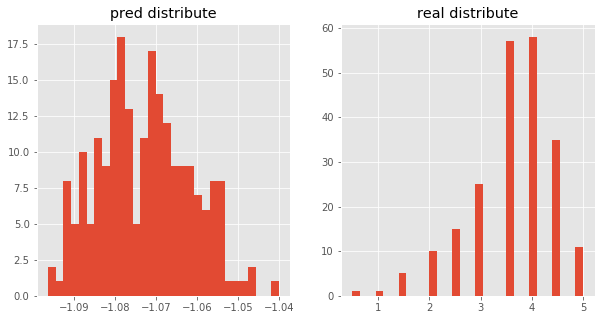

In [45]:
# user id from 0 ~ 670
uid = 22
with tf.Session(graph=model.graph) as sess:
    pred = model.predict(sess, [uid])
print("shape: ", pred.shape, pred)

nnzCoord = teRatingMat[uid].nonzero()
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("pred distribute")
pd.Series(pred.ravel()[nnzCoord]).hist(bins=30, ax=ax[0])
ax[1].set_title("real distribute")
pd.Series(map(lambda e: e, teRatingMat[uid][nnzCoord])).hist(bins=30, ax=ax[1])
plt.show()

<br/>
<br/>
<br/>
## evaluate model

In [29]:
%%time
with tf.Session(graph=model.graph) as sess:
    mae_ = model.evaluateMAE(sess, dataFn(te))
    rmse_ = model.evaluateRMSE(sess, dataFn(te))

print()
print("MAE loss: ", mae_)
print("RMSE loss: ", rmse_)

INFO:tensorflow:Restoring parameters from ./model/model_mf/model-20
INFO:tensorflow:Restoring parameters from ./model/model_mf/model-20

MAE loss:  2.7244679631175726
RMSE loss:  2.909191494129091
CPU times: user 395 ms, sys: 37.2 ms, total: 432 ms
Wall time: 377 ms


#### User導向評估(Recall)

In [30]:
# 可給定user id細看每個user的rating與model預測效果
# valid user id from 0 ~ 670
uid = 22
with tf.Session(graph=model.graph) as sess:
    recomm = model.predict(sess, [uid]).ravel()
recommDf = pd.DataFrame(data={
              "userId": uid,
              "movieId": range(len(recomm)),
              "title": midMap[np.arange(len(recomm))].values,
              "rating": teRatingMat[uid, range(len(recomm))],
              "predRating": recomm},
             columns=("userId", "movieId", "title", "rating", "predRating"))
# ascending 可以調整True or False觀察結果
recommDf.query("rating != 0").sort_values("rating", ascending=False)

INFO:tensorflow:Restoring parameters from ./model/model_mf/model-20


,userId,movieId,title,rating,predRating
4417,22,4417,Catch Me If You Can (2002),5.0,0.848976
5623,22,5623,Undertow (2004),5.0,0.875625
4419,22,4419,"Hours, The (2002)",5.0,0.851034
4432,22,4432,City of God (Cidade de Deus) (2002),5.0,0.867132
4371,22,4371,Adaptation (2002),5.0,0.852828
4008,22,4008,And Your Mother Too (Y tu mamá también) (2001),5.0,0.850735
6132,22,6132,Crash (2004),5.0,0.861424
5016,22,5016,Stolen Kisses (Baisers volés) (1968),5.0,0.878984
5761,22,5761,Duel (1971),5.0,0.882730
4875,22,4875,"Unvanquished, The (Aparajito) (1957)",5.0,0.866140


#### Model導向評估(Precision)

In [31]:
print("recommend for user {}".format(uid))
# .query("rating != 0")
recommDf.query("rating != 0").sort_values("predRating", ascending=False)

recommend for user 22


,userId,movieId,title,rating,predRating
5127,22,5127,Eternal Sunshine of the Spotless Mind (2004),4.5,0.887388
4111,22,4111,Insomnia (2002),3.5,0.887198
4622,22,4622,"White Sheik, The (Sceicco bianco, Lo) (1952)",3.5,0.884102
4241,22,4241,Heaven (2002),4.5,0.883678
4949,22,4949,Things You Can Tell Just by Looking at Her (2000),4.0,0.883312
5485,22,5485,Spider-Man 2 (2004),3.5,0.883179
5761,22,5761,Duel (1971),5.0,0.882730
4102,22,4102,About a Boy (2002),3.5,0.882694
5583,22,5583,"Motorcycle Diaries, The (Diarios de motociclet...",4.5,0.882343
4268,22,4268,"Grey Zone, The (2001)",3.5,0.881140


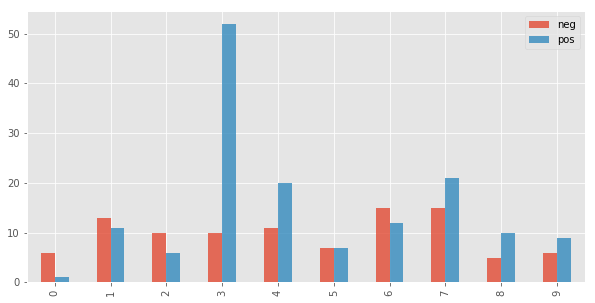

In [32]:
pos_ary, neg_ary = [], []
for label in teRatingMat:
    label = label[label != 0]
    pos_ary.append(sum(label >= 4))
    neg_ary.append(sum(label < 4))
    # print("pos: {}, neg: {}".format(sum(label >= 4), sum(label < 4)))
    
def draw_pos_neg(idx):
    pd.DataFrame(
        index=idx,
        data={"pos": np.array(pos_ary)[idx], "neg": np.array(neg_ary)[idx]}).plot.bar(figsize=(10, 5), alpha=0.8)
    plt.show()

draw_pos_neg(np.arange(len(teRatingMat))[0:10])

### About Test Data Movie Ratings(觀察上圖)
1. 0號, 2號, 5號, 9號 user 正向評價數量 < 10, 就算model全部預測命中, 命中率也不會是 100%!
    ex: 0號user只有1個正向評價, 全部命中也指得到0.1的分數
2. 3號user正向評價是負向評價的5倍多, 就算亂猜, 中的機率也很高

In [33]:
_ = sum(np.sum(teRatingMat >= 4, 1) < 10)
print("{} 個user正向評價總數小於10!".format(_))

266 個user正向評價總數小於10!


In [34]:
print("rating數量 >= 10 且 負評價數量 >= 正評價數量 有 [{}] 人".format(sum(strict_condition(label) for label in teRatingMat)))
print("rating正評價數量 >= 0 且 rating負評價數量 >= 0 有 [{}] 人".format(sum(norm_condition(label) for label in teRatingMat)))

rating數量 >= 10 且 負評價數量 >= 正評價數量 有 [209] 人
rating正評價數量 >= 0 且 rating負評價數量 >= 0 有 [669] 人


#### Precision At K: 
> **預測分數高(rating >= 4)的前10部電影, 和實際user rating比較, 觀察命中率**

In [35]:
%%time
from sklearn.metrics import precision_score
with tf.Session(graph=model.graph) as sess:
    pred_mat = []
    users = np.arange(nUsers)
    for pos in range(0, nUsers, 200):
        batch = users[pos:pos + 200]
        pred_mat.append(model.predict(sess, batch))
    pred_mat = np.vstack(pred_mat)
    
print( "strict condition precision at 10: ", precision_at_k(teRatingMat, pred_mat, strict_condition, k=10) )
print( "norm condition precision at 10: ", precision_at_k(teRatingMat, pred_mat, norm_condition, k=10) )

INFO:tensorflow:Restoring parameters from ./model/model_mf/model-20
INFO:tensorflow:Restoring parameters from ./model/model_mf/model-20
INFO:tensorflow:Restoring parameters from ./model/model_mf/model-20
INFO:tensorflow:Restoring parameters from ./model/model_mf/model-20
strict condition precision at 10:  0.39330143540669854
norm condition precision at 10:  0.5509715994020927
CPU times: user 1.96 s, sys: 154 ms, total: 2.11 s
Wall time: 1.76 s


### NDCG: Normalized Discounted Cumulative Gain
1. A measure of ranking quality.
2. loop 每一位user, prediciton score排序後計算NDCG
    <br/>$$ DCG_p = \sum^p_{i = 1} \frac{2^{rel_i} - 1}{log_2(i + 1)} $$<br/>
3. IDCG: Ideal DCG, 為理想狀態下的DCG分數, 即model全部命中的DCG分數, 而NDCG: Normalized DCG, 公式如下
    <br/>$$ NDCG_p = \sum^p_{i = 1} \frac{DCG_p}{IDCG_p} $$<br/>
4. 所以NDCG是一個比值, 介於0 ~ 1之間

In [36]:
with tf.Session(graph=model.graph) as sess:
    pred_mat = []
    users = np.arange(nUsers)
    for pos in range(0, nUsers, 200):
        batch = users[pos:pos + 200]
        pred_mat.append(model.predict(sess, batch))
    pred_mat = np.vstack(pred_mat)
    
strict_ndcg = all_user_ndcg(teRatingMat, pred_mat, strict_condition, label_thres=4, k=10)
norm_ndcg = all_user_ndcg(teRatingMat, pred_mat, norm_condition, label_thres=4, k=10)
print("strict condition ndcg at 10: ", strict_ndcg)
print("norm condition ndcg at 10: ", norm_ndcg)

INFO:tensorflow:Restoring parameters from ./model/model_mf/model-20
INFO:tensorflow:Restoring parameters from ./model/model_mf/model-20
INFO:tensorflow:Restoring parameters from ./model/model_mf/model-20
INFO:tensorflow:Restoring parameters from ./model/model_mf/model-20
strict condition ndcg at 10:  0.4571533388148279
norm condition ndcg at 10:  0.638480408920308


#### ROC_CURVE (Receiver operating characteristic), AUC (Area Under Curve)

INFO:tensorflow:Restoring parameters from ./model/model_mf/model-20
auc: 0.513604937822618


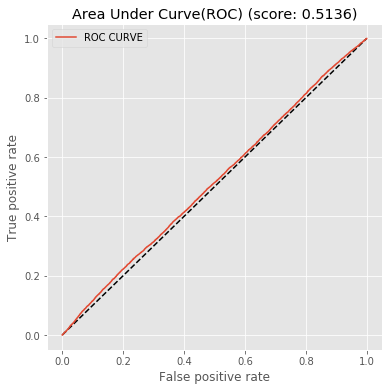

In [37]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
    
# 只看非0的部分
coord = teRatingMat.nonzero()
with tf.Session(graph=model.graph) as sess:
    predMat = model.predict(sess, np.arange(teRatingMat.shape[0]).tolist())
    predMat = predMat / predMat.max()
    
# regard rating >= 4 as user like this movie
drawRocCurve((teRatingMat[coord] >= 4).astype(int), predMat[coord])
# ind = predMat[coord].argsort()
# drawRocCurve((teRatingMat[coord] >= 4).astype(int)[ind], predMat[coord][ind[::-1]])

## Observations
+ AUC = 0.5 (no discrimination 無鑑別力)
+ 0.7 ≦ AUC ≦ 0.8 (可接受的鑑別力)
+ 0.8 ≦ AUC ≦ 0.9 (優良的鑑別力)
+ 0.9 ≦ AUC ≦ 1.0 (極佳的鑑別力)
<br/>
<br/>
<br/>

## Google Play App上推薦系統Model分數(Wide and Deep Model)
[Paper: Wide & Deep Learning for Recommender Systems](https://arxiv.org/pdf/1606.07792.pdf)

![google_wnd_auc](https://github.com/CloudMile/recommendation_engine_course/blob/master/google_wnd_auc.jpg?raw=true)
    1. 分數只有0.728, 但是不要認為這是不好的
    2. 評分時也要考慮到系統規模等等其他的context information, 如果您有辦法在大規模的系統有AUC 0.7以上的分數, 已經是很難的的分數了
    3. 更實際的指標很有可能是AB Test

<br/>
<br/>
<br/>

## 取出movies embedding, 使用cosine similarity列出最相似的電影
![graph_embedding_utils](https://github.com/CloudMile/recommendation_engine_course/blob/master/graph_embedding_utils.jpg?raw=true)

In [38]:
movies[movies.title.str.contains("Toy")]

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1579,1579,Babes in Toyland (1961),Children|Fantasy|Musical
1780,1780,Toys (1992),Comedy|Fantasy
2479,2479,Babes in Toyland (1934),Children|Comedy|Fantasy|Musical
2506,2506,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
3829,3829,"Toy, The (1982)",Comedy
4341,4341,Toy Soldiers (1991),Action|Drama
7556,7556,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX
8437,8437,Toy Story of Terror (2013),Animation|Children|Comedy


In [39]:
from sklearn.metrics.pairwise import cosine_similarity
def most_like(model, seed_movie, k=10):
    with tf.Session(graph=model.graph) as sess:
        model.ckpt(sess, model.modelDir)
        movie_emb = sess.run(model.embd_item, feed_dict={model.item_batch: movies.movieId.values})
        
    most_like = cosine_similarity(movie_emb[seed_movie][np.newaxis, :], movie_emb).ravel().argsort()[::-1][:k]
    return movies.iloc[most_like]

most_like(model, 0, k=10)

INFO:tensorflow:Restoring parameters from ./model/model_mf/model-20


,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
6391,6391,Lights in the Dusk (Laitakaupungin valot) (2006),Crime|Drama
248,248,Milk Money (1994),Comedy|Romance
2136,2136,Pork Chop Hill (1959),War
8914,8914,The Hunger Games: Mockingjay - Part 2 (2015),Adventure|Sci-Fi
5476,5476,By the Light of the Silvery Moon (1953),Children|Musical|Romance
7585,7585,Cherrybomb (2009),Drama|Thriller
128,128,Amateur (1994),Crime|Drama|Thriller
4912,4912,"Cabinet of Dr. Caligari, The (Cabinet des Dr. ...",Crime|Fantasy|Horror
6833,6833,Smiley Face (2007),Comedy
